In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import roc_auc_score , roc_curve , auc


In [2]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_root = Path('../data/carpet/train')
test_root = Path('../data/carpet/test')
gt_root   = Path('../data/carpet/ground_truth')

good_dataset = ImageFolder(root=train_root, transform=transform)
train_dataset, _ = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [3]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False

        self.features = []

        def hook(module, input, output):
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

        self.avg_pool = nn.AvgPool2d(kernel_size =3, stride=1, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        self.features = []
        with torch.no_grad():
            _ = self.model(x)

        f2, f3 = self.features  

        f2 = self.avg_pool(f2)
        f3 = self.avg_pool(f3)

        target_size = f2.shape[-2:]
        f3 = F.interpolate(f3, size=target_size, mode='bilinear', align_corners=False)

        # concatenate 
        patch_features = torch.cat([f2, f3], dim=1)  # [B, C, H, W]

        # for baseline model
        global_features = self.gap(patch_features)
        global_features = global_features.view(global_features.size(0), -1)  # [B, C]

        return patch_features, global_features
    
backbone = ResNetFeatureExtractor().eval()


In [4]:
all_patches = []

for images, _ in train_loader:
    with torch.no_grad():
        patch_feat, _ = backbone(images)
        B, C, H, W = patch_feat.shape
        patches = patch_feat.permute(0,2,3,1).reshape(-1, C)
        all_patches.append(patches.cpu())

all_patches = torch.cat(all_patches, dim=0)


In [5]:
mu = all_patches.mean(dim=0)
var = all_patches.var(dim=0)       

In [6]:
def psfe_score(patch_feat, mu, var, lam=0.2 ,use_entropy = True):
    d_var = ((patch_feat - mu) ** 2) / (var + 1e-6)
    d_var = d_var.mean()

    if not use_entropy:
        return d_var

    p = F.softmax(patch_feat, dim=0)
    entropy = -torch.sum(p * torch.log(p + 1e-8))

    return d_var + lam * entropy


Generate anomaly map

In [7]:
def generate_anomaly_map(image, backbone, mu, var):
    with torch.no_grad():
        patch_feat, _ = backbone(image.unsqueeze(0))
        patch_feat = patch_feat.squeeze(0)

    C, H, W = patch_feat.shape
    anomaly_map = torch.zeros(H, W)

    for i in range(H):
        for j in range(W):
            anomaly_map[i, j] = psfe_score(patch_feat[:, i, j], mu, var,use_entropy=False)

    anomaly_map = anomaly_map.numpy()
    min_val = anomaly_map.min()
    max_val = anomaly_map.max()
    anomaly_map = (anomaly_map - min_val) / ( max_val - min_val + 1e-8)
    
    return anomaly_map

In [32]:
pixel_aucs = []
all_pixel_scores = []
all_pixel_labels = []


for defect_type in os.listdir(test_root):
    if defect_type == 'good':
        continue

    defect_path = test_root / defect_type
    gt_path = gt_root / defect_type

    for img_name in os.listdir(defect_path):
        img = Image.open(defect_path / img_name)
        img = transform(img)

    anomaly_map = generate_anomaly_map(img, backbone, mu, var)

    mask_name = img_name.replace('.png', '_mask.png')
    gt_mask = Image.open(gt_path / mask_name).convert('L')
    gt_mask = gt_mask.resize((anomaly_map.shape[1], anomaly_map.shape[0]))
    gt_mask = (np.array(gt_mask) > 0).astype(np.uint8)

    auc_val = roc_auc_score(gt_mask.flatten(), anomaly_map.flatten())
    pixel_aucs.append(auc_val)

    all_pixel_scores.extend(anomaly_map.flatten())
    all_pixel_labels.extend(gt_mask.flatten())

print(f"Mean Pixel-level AUROC: {np.mean(pixel_aucs):.6f}")
print(f"Std Pixel-level AUROC: {np.std(pixel_aucs):.6f}")

Mean Pixel-level AUROC: 0.989488
Std Pixel-level AUROC: 0.005129


### Experimenting: Effect of Entropy Inclusion

| Method | Mean Pixel AUROC | Std |
|------|------------------|-----|
| PSFE (variance only) | 0.989488 | 0.005129 |
| PSFE (variance + entropy) | 0.989431 | 0.005169 |

Including entropy does not significantly affect pixel-level AUROC . Though detection performance 
is similar, entropy helps stabilize patch responses.


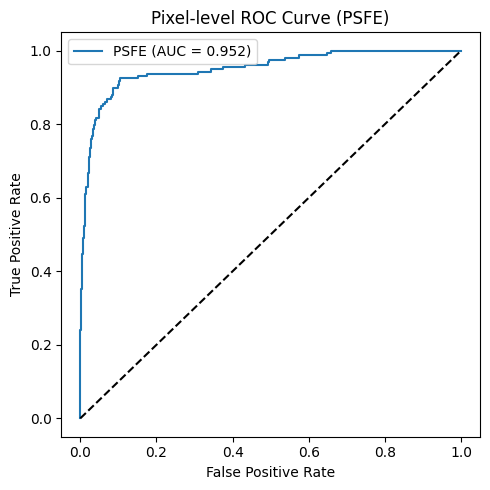

In [15]:
fpr, tpr, _ = roc_curve(all_pixel_labels, all_pixel_scores)
pixel_roc_auc = auc(fpr, tpr)


plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'PSFE (AUC = {pixel_roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pixel-level ROC Curve (PSFE)')
plt.legend()
plt.tight_layout()
plt.show()

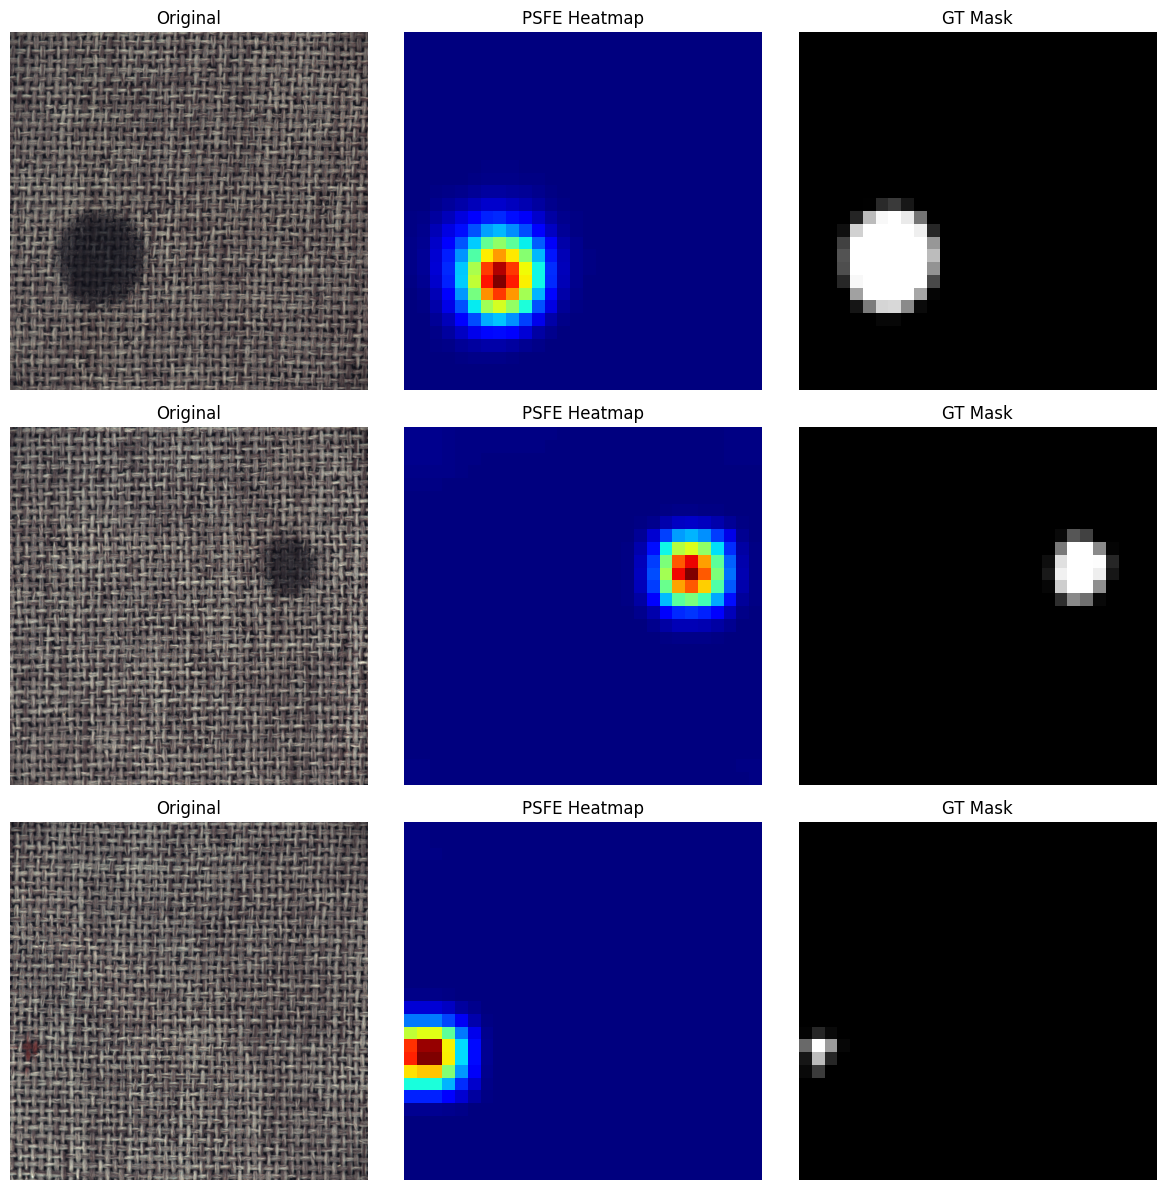

In [35]:
samples = [('color', '000.png'), ('color', '004.png'), ('color', '013.png')]

fig, axes = plt.subplots(len(samples), 3, figsize=(12, 4 * len(samples)))

for idx, (defect, img_name) in enumerate(samples):
    img_path = test_root / defect / img_name
    gt_path = gt_root / defect / img_name.replace('.png', '_mask.png')

    image_pil = Image.open(img_path)
    image = transform(image_pil)

    anomaly_map = generate_anomaly_map(image, backbone, mu, var)

    gt_mask = Image.open(gt_path).convert('L')
    gt_mask = gt_mask.resize((anomaly_map.shape[1], anomaly_map.shape[0]))

    axes[idx, 0].imshow(image_pil)
    axes[idx, 0].set_title('Original')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(anomaly_map, cmap='jet')
    axes[idx, 1].set_title('PSFE Heatmap')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(gt_mask, cmap='gray')
    axes[idx, 2].set_title('GT Mask')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

### Generalization to Other MVTec Categories


In [9]:
categories = ["grid", "bottle" , "capsule"]

In [ ]:
def evaluate_psfe_category(category):
    train_root = Path(f"../data/{category}/train")
    test_root  = Path(f"../data/{category}/test")
    gt_root    = Path(f"../data/{category}/ground_truth")

    dataset = ImageFolder(train_root, transform=transform)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    all_patches = []
    for images, _ in loader:
        with torch.no_grad():
            patch_feat, _ = backbone(images)
            B, C, H, W = patch_feat.shape
            patches = patch_feat.permute(0,2,3,1).reshape(-1, C)
            all_patches.append(patches.cpu())

    all_patches = torch.cat(all_patches, dim=0)
    mu  = all_patches.mean(dim=0)
    var = all_patches.var(dim=0)

    pixel_aucs = []

    for defect_type in os.listdir(test_root):
        if defect_type == "good":
            continue

        for img_name in os.listdir(test_root / defect_type):
            img = Image.open(test_root / defect_type / img_name).convert("RGB")
            img = transform(img)

            anomaly_map = generate_anomaly_map(img, backbone, mu, var)

            gt_mask = Image.open(
                gt_root / defect_type / img_name.replace(".png", "_mask.png")
            ).convert("L")

            gt_mask = gt_mask.resize((anomaly_map.shape[1], anomaly_map.shape[0]))
            gt_mask = (np.array(gt_mask) > 0).astype(np.uint8)

            auc = roc_auc_score(gt_mask.flatten(), anomaly_map.flatten())
            pixel_aucs.append(auc)

    return np.mean(pixel_aucs), np.std(pixel_aucs)


In [ ]:
results = {}

for cat in categories:
    mean_auc, std_auc = evaluate_psfe_category(cat)
    results[cat] = (mean_auc, std_auc)
    print(f"{cat}: Mean Pixel AUROC = {mean_auc:.4f}, Std = {std_auc:.4f}")


grid: Mean Pixel AUROC = 0.9339, Std = 0.0768
bottle: Mean Pixel AUROC = 0.9625, Std = 0.0404
capsule: Mean Pixel AUROC = 0.9441, Std = 0.0529


### PSFE Performance Across Categories

| Category | Mean Pixel AUROC | Std |
|--------|------------------|-----|
| Carpet | 0.989 | 0.005 |
| Grid | 0.934 | 0.077 |
| Bottle | 0.963 | 0.041 |
| Capsule | 0.944 | 0.053 |
